In [50]:
%matplotlib inline

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.00298222  0.00257952 ...,  0.00230454  0.0025256   0.        ]
 [ 0.          0.00680859  0.00589684 ...,  0.00323842  0.00288753  0.        ]
 ..., 
 [ 0.          0.06429785  0.11279683 ...,  0.06202925  0.11588951  0.        ]
 [ 0.          0.08467624  0.00870733 ...,  0.09273338  0.07020751  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


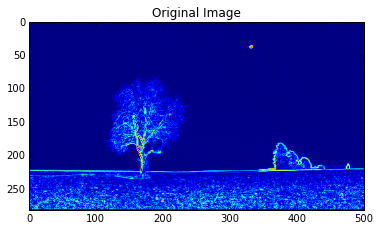

In [51]:
from skimage import data, draw,color, data, restoration
from skimage import transform, util
import numpy as np
from skimage import filters, color
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.animation as animation
from scipy.misc import imresize
from scipy import ndimage as nd


img =  plt.imread('countryside.jpg')

img = util.img_as_float(img)
grad = filters.sobel(color.rgb2gray(img))
print grad
plt.title('Original Image')
plt.imshow(grad)

In [52]:
#normalitzacio d'imatge
def normalitzar(image):
    return np.real((image - np.min(image)) * 256 / (np.max(image) - np.min(image)))

In [53]:

#Calcul matriu d'energia que te cada zona
def energia(im):
    height,width = im.shape
    energia=np.zeros(im.shape)
    #asignem la primera linea igual que la imatge que tenim
    energia[0]=im[0]   
    for x in range(1,height):
        for y in range(0,width):
            if y == 0:
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
            elif y < width - 2:
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
                min_val = min( min_val, energia[x-1, y-1] )
            else:
                min_val = min( energia[x-1, y], energia[x-1, y-1] )
            energia[x,y] = im[x,y] + min_val
    return energia
            
    
    

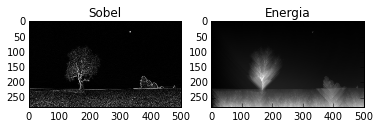

In [54]:
#grad=normalitzar(grad)
E = energia(grad)
#print energy
plt.subplot(1,2,1)
plt.imshow(normalitzar(grad), cmap="gray")
plt.title('Sobel')
plt.subplot(1,2,2)
plt.imshow(normalitzar(E), cmap="gray" )
plt.title('Energia')



In [73]:
# El calcul del tall vertical hem de buscar el cami amb cost minim. BACKTRACKING
# Aquest tall pot ser vertical o horitzontal, es un camí de pixels connectats. En el nostre cas l'apliquem vertical
# La función de importancia / energía valora un píxel mediante la medición de su contraste con sus píxeles vecinos.
# Des de la imatge en escala de grisos retornarem el tall vertical mes baix com a llista de pixels

def tall_vertical(fila, column, imatge, llista):
    # Anem fins al -1 perque aixi es quedara en el 0, que tambe el necessitem.
    for fila in range(imatge.shape[0], -1, -1):
        if column == 0:
            min_val = min( imatge[fila-1, column], imatge[fila-1, column+1] )
            if min_val == imatge[fila-1, column+1]:
                column = column + 1            
        elif column < imatge.shape[1] - 2:
            min_val = min( imatge[fila-1,column-1], imatge[fila-1,column] )
            min_val = min( min_val, imatge[fila-1,column+1] )
            if min_val == imatge[fila-1, column-1]:
                column = column - 1 
            elif min_val == imatge[fila-1, column+1]:
                column = column + 1 
        else:
            min_val = min( imatge[fila-1, column], imatge[fila-1, column-1] )
            if min_val == imatge[fila-1, column-1]:
                column = column - 1 
        llista.append([fila, column])        
    return llista 

h, w = E.shape
linia = E[h-1]             # Aqui agafem l'ultima linia per buscar les 100 posicions minimes a borrar el fil
liniaOrdenada = sorted(linia)
llistaBacktracking = []               # Amb aquesta llista farem el backtracking, son les posicions dels 100 minims
ultimNombre = -1
for i in range(20):
    if ultimNombre != liniaOrdenada[i]:
        ultimNombre = liniaOrdenada[i]
        pos = np.where(linia == liniaOrdenada[i])    # Busquem quins son els minims
        for x in range(len(pos[0])):
            llistaBacktracking.append(pos[0][x])
        
print llistaBacktracking    

[0, 1, 499, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]


[[281, 322], [280, 323], [279, 323], [278, 322], [277, 321], [276, 322], [275, 322], [274, 321], [273, 321], [272, 321], [271, 322], [270, 322], [269, 323], [268, 323], [267, 324], [266, 325], [265, 326], [264, 327], [263, 327], [262, 328], [261, 327], [260, 327], [259, 328], [258, 327], [257, 326], [256, 326], [255, 325], [254, 325], [253, 324], [252, 324], [251, 324], [250, 325], [249, 326], [248, 325], [247, 325], [246, 325], [245, 324], [244, 323], [243, 323], [242, 324], [241, 324], [240, 323], [239, 324], [238, 324], [237, 323], [236, 324], [235, 323], [234, 323], [233, 323], [232, 323], [231, 322], [230, 321], [229, 320], [228, 319], [227, 318], [226, 319], [225, 320], [224, 321], [223, 320], [222, 319], [221, 320], [220, 320], [219, 321], [218, 322], [217, 323], [216, 324], [215, 324], [214, 325], [213, 326], [212, 327], [211, 328], [210, 329], [209, 330], [208, 331], [207, 332], [206, 333], [205, 334], [204, 335], [203, 336], [202, 337], [201, 338], [200, 339], [199, 340], [19

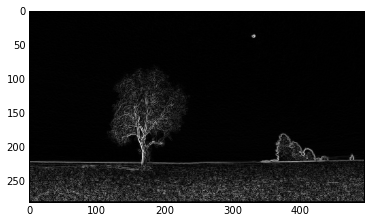

In [75]:
def borrar_cami (img, path):
    height, width = img.shape[:2]
    img_retallada = np.zeros((height, width-1))
    path_cpy = path
    visitat = []
    for x in range(height):
        for y in range(width-1):
            if (x,y) not in path_cpy and x not in visitat:
                img_retallada[x,y] = img[x,y]
            elif (x,y) in path_cpy:
                visitat.add(x)
            else:
                img_retallada[x,y-1] = img[x,y]
    #print "Deletion Complete."
    return img_retallada;
print tall_vertical(h, llistaBacktracking[2], E, path)    
#path = tall_vertical(h, llistaBacktracking[0], E, path) 
#grad = borrar_cami(grad, path)
#plt.subplot(1,2,1)
#plt.imshow(normalitzar(grad), cmap="gray")
#for t in range (50): 
#    path = []
#    tall_vertical(h, llistaBacktracking[t], E, path)
#    grad = borrar_cami(grad, path)
#plt.subplot(1,2,2)   
plt.imshow(normalitzar(grad), cmap="gray")
print grad.shape

In [58]:
    i=path
    #print "Deleting Vertical Seam..."
    img_height, img_width = img.shape[:2] 
    print img_height, img_width 
    #i = np.zeros((img_height, img_width-1, img.shape[2]))
                 
    #path_set = set(path)
    seen_set = set()
    print seen_set
    for x in range(img_height):
        for y in range(img_width):
            if (x,y) not in path and x not in seen_set:
                i[x,y] = img[x,y]
    #        elif (x,y) in path_set:
    #            seen_set.add(x)
    #        else:
    #            i[x,y-1] = img[x,y]
    #print "Deletion Complete."

281 500
set([])


TypeError: list indices must be integers, not tuple